# Equations of State

## Setup

In [1]:
from matplotlib import colors, cm, colormaps as cmaps, pyplot as plt
import numpy as np

from carpy.physicalchem import eostate, species, UnreactiveFluidModel
from carpy.utility import Quantity

In [2]:
# For looping, we'll define an iterable for the equations of state to test
equations_of_state = (eostate.IdealGas, eostate.VdW, eostate.RK, eostate.SRK, eostate.SRKmP, eostate.PR, eostate.BH2)

In [3]:
# For temperature colouration, use a colour map where the normalised temperature is white
cmap = plt.get_cmap("coolwarm")

def get_colour(x):
    """Get (R, G, B, A) scaled with reduced temperature array, such that T_r=1.0 corresponds to white."""
    y = np.interp(x, (T_rs.min(), 1.0, T_rs.max()), (0, 0.5, 1.0))
    c = cmap(y)
    return c

## Pure Fluid Phase Diagrams

In the below section, several equations of state are compared.
By plotting fluid density against the fluid temperature and pressure, we can clearly identify the vapour-liquid equilibrium boundary.

Equations of state in general struggle more with computations for liquid density than gas density due to increasing influence of inter-molecular forces.

The Soave-Redlich-Kwong model appears to perform the best for simple molecules without complicated intermolecular interactions.
For water molecules, the intermolecular hydrogen-bonding causes water to have a higher density than would otherwise be predicted for similarly sized molecules.
This causes many models to underpredict the density of water.

The Peneloux-modified SRK model more accurately captures the density of water thanks to the use of a corrective molar volume offset, which translates all molar volume results.
Conceptually, a small molar volume offset has a relatively small impact on the vapour density but a larger and desirable impact on the liquid density.
As this factor depends on each individual species, an ansatz value must be used wherever an offset is unavailable.
**As of 18/09/2024, an ansatz value is provided automatically to Pendeloux models and  is based on fitting to petroleum products.**

In [4]:
# Data generation options
resolution = 60

# Figure parameters
figwidth = 11
ncols = 3
aspect = 1.6

In [5]:
def plot_density_maps(chem_species) -> None:
    """
    Given a pure chemical species, compute the density of the fluid per available equation of state models.

    If a liquid phase is detected, its density is annotated - else the annotation describes vapour density.

    Args:
        chem_species: A chemical species object, describing a pure substance.

    """
    # Pressure and temperature limits are autoscaled w.r.t critical pressure and temperature
    p = Quantity(np.logspace(0, np.round(np.log10(float(chem_species.p_c)) + 0.3), resolution), "Pa")
    T = Quantity(np.linspace(1e-3, (Tmargin := 1.1) * float(chem_species.T_c), resolution), "K")
    pgrid, Tgrid = np.meshgrid(p, T)
    
    # Compute colourmap data
    dens_data = dict()
    dens_poi = dict()
    for i, EOS in enumerate(equations_of_state):
        print(f"\r({i+1}/{len(equations_of_state)}) {EOS.__name__:<20s}", end="")
    
        # Instantiate a model with the given equation of state
        model = UnreactiveFluidModel(eos_class=EOS)
        model.X = {chem_species: 1.0}
    
        # Compute density data
        dens_data[EOS] = model.density(p=pgrid, T=Tgrid)

        # On the 1 atm line, look left for the temperature of the phase boundary and get the density there
        pressure_boil = Quantity(1, "atm")
        temp_to_try = np.linspace(0.90, 1.0, 11) * chem_species.T_boil
        threshold = 3 * model.density(p=pressure_boil, T=chem_species.T_boil)  # Threshold = change of 3x in the density
        dens_to_try = model.density(p=pressure_boil, T=temp_to_try)
        discontinuities = (abs(np.diff(dens_to_try)) > threshold)

        # The index of the discontinuity indicates where the equation of state transitions
        if len(discontinuities) == 0 or not np.any(discontinuities):
            temperature_boil = chem_species.T_boil
            dens_poi[EOS] = model.density(p=pressure_boil, T=temperature_boil)
        else:
            idx = np.where(discontinuities)[0][-1]  # Lowest temperature == highest density == most likely to be liquid
            temperature_boil = temp_to_try[idx]
            dens_poi[EOS] = dens_to_try[idx]
    
    else:
        print(f"\n{'Finished computing':<20s}")

    dens_hi = max([np.percentile(v, 95) for (_, v) in dens_data.items()])
    
    # Create figure
    nrows = int(np.ceil(len(equations_of_state) / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True)
    fig.set_figwidth(figwidth)
    fig.set_figheight((figwidth / aspect) * (nrows / ncols))
    fig.suptitle(f"Equation of State models for Pure {chem_species}", x=0.45, y=0.96)
    
    # Prepare figure-wide colour map
    normaliser = colors.Normalize(0, dens_hi)
    cmap = plt.get_cmap("viridis")
    
    # Compute colourmap data
    for i, EOS in enumerate(equations_of_state):
    
        ax = axs.flat[i]
        ax.set_title(f"`{EOS.__name__}'")
        ax.set_yscale("log")
        ax.set_ylim(p.min(), p.max())
        ax.set_xlabel(f"Temperature [{T.u.mathtext_si}]")
        ax.set_ylabel(f"Pressure [{p.u.mathtext_si}]")
        ax.label_outer()
        ax.axvline(chem_species.T_boil, c="r", alpha=0.4)
        
        # Plot computed data
        ax.pcolormesh(Tgrid, pgrid, dens_data[EOS], norm=normaliser)
        ax.annotate(
            text=f"$\\rho=${float(dens_poi[EOS]):.3f}\n  {dens_poi[EOS].u.mathtext_si}",
            xy=(temperature_boil, pressure_boil),
            xytext=((chem_species.T_boil / (Tmargin * 1.3), Quantity(1, "atm") / 50)),
            va="top",
            arrowprops={"arrowstyle": "-|>", "color": "white", "lw": 2},
            c="white",
        )
        
    im = cm.ScalarMappable(norm=normaliser, cmap=cmap)
    cbar = fig.colorbar(im, ax=list(axs.flatten()))
    cbar.set_label(f"Density [{dens_data[EOS].u.mathtext_si}]")
    plt.show()

    return None

### Helium

(7/7) BaigangH2           
Finished computing  


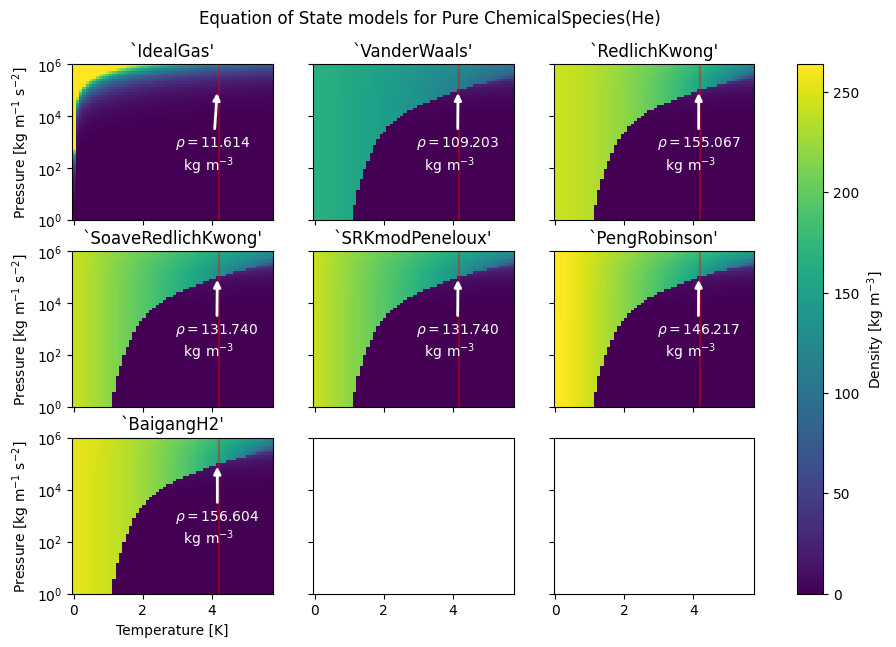

In [6]:
plot_density_maps(species.helium())

Liquid helium has a density of about 125 [kg/m3] at the normal boiling condition.

### Hydrogen

(7/7) BaigangH2           
Finished computing  


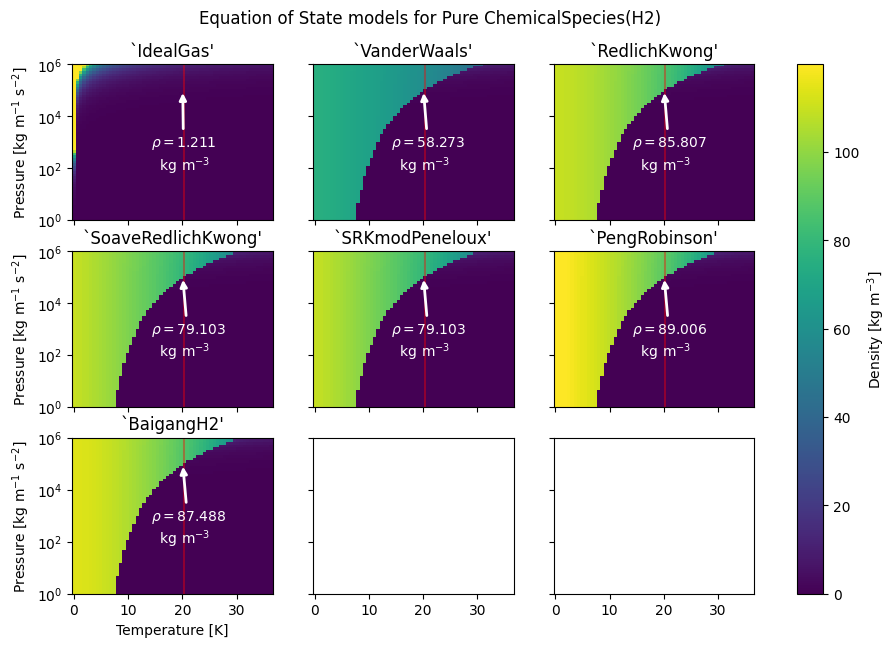

In [7]:
plot_density_maps(species.hydrogen())

<div class="alert alert-block alert-info"> <b>📝 Note:</b>
    It is a coincidence that the ideal gas density close to the normal boiling temperature of hydrogen is close to the value of sea-level density of air under standard atmospheric conditions. The ratio of considered temperatures is very close to the molar mass ratios of hydrogen and dry air: $$\frac{288\text{ K}}{20\text{ K}} \approx \frac{29\text{ g/mol}}{2\text{ g/mol}}$$
</div>

Liquid hydrogen has a density of about 71 [kg/m3] at the normal boiling condition.

### Water

(7/7) BaigangH2           
Finished computing  


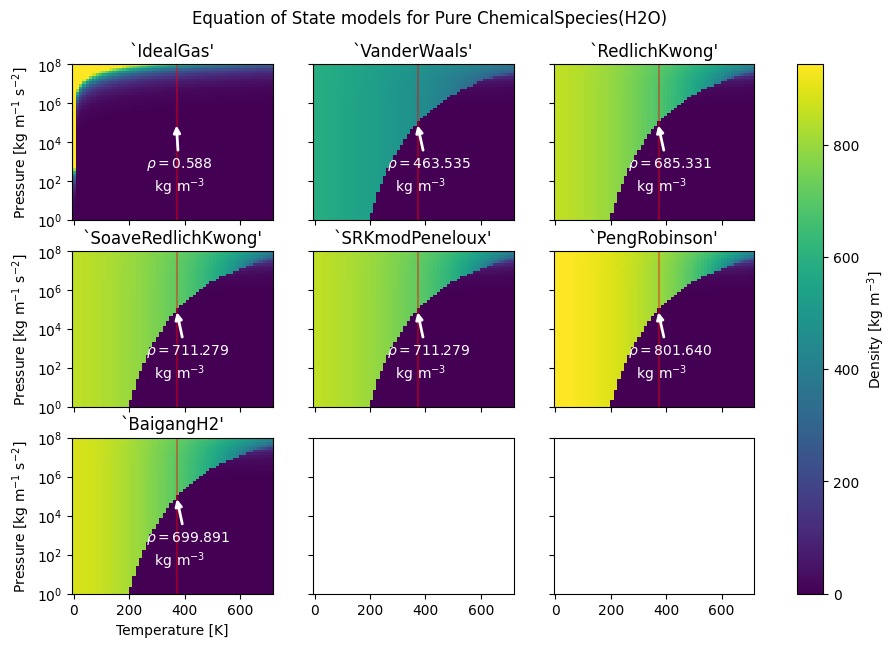

In [8]:
plot_density_maps(species.water())

Liquid water has a density of 958 [kg/m3] at the normal boiling condition.

### Nitrogen

(7/7) BaigangH2           
Finished computing  


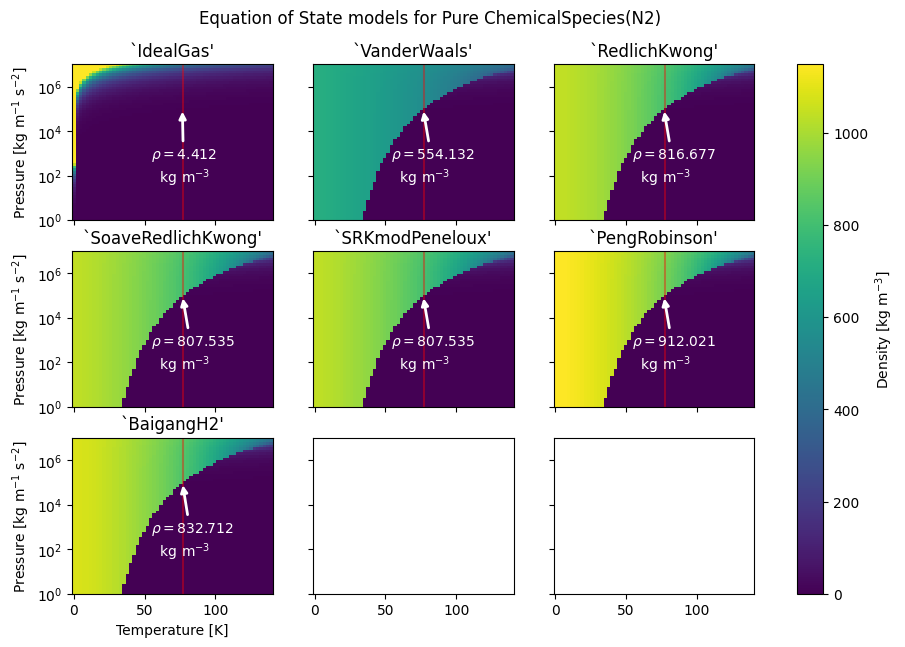

In [9]:
plot_density_maps(species.nitrogen())

Liquid nitrogen has a density of about 807 [kg/m3] at the normal boiling condition.

### Methane

(7/7) BaigangH2           
Finished computing  


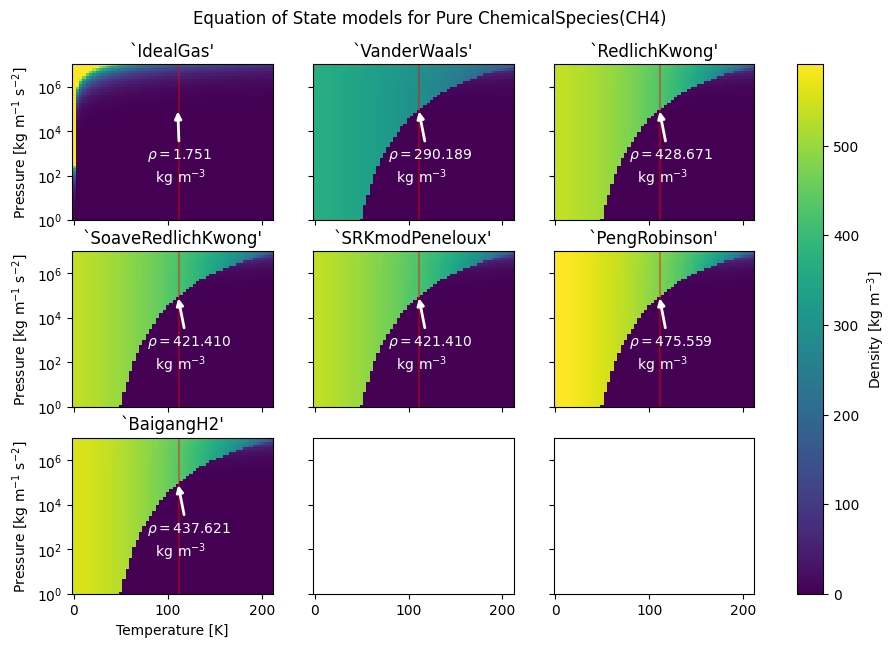

In [10]:
plot_density_maps(species.methane())

Liquid methane has a density of about 422.6 [kg/m3] at the normal boiling condition.